In [5]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [6]:
root_dir = "/Users/prisriva/Desktop/fai_final"
data_root = os.path.join(root_dir, "data", "raw")

train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

train_img_dir = os.path.join(train_dir, "images")
val_img_dir   = os.path.join(val_dir, "images")
test_img_dir  = os.path.join(test_dir, "images")

train_ann = os.path.join(train_dir, "annotations.json")
val_ann   = os.path.join(val_dir, "annotations.json")
test_ann  = os.path.join(test_dir, "annotations.json")

In [7]:
def load_coco_json(path):
    with open(path, "r") as f:
        return json.load(f)

train_data = load_coco_json(train_ann)
val_data   = load_coco_json(val_ann)
test_data  = load_coco_json(test_ann)

print("Loaded JSON:")
print(f"  Train: {len(train_data['images'])} images, {len(train_data['annotations'])} annos")
print(f"  Val:   {len(val_data['images'])} images, {len(val_data['annotations'])} annos")
print(f"  Test:  {len(test_data['images'])} images, {len(test_data['annotations'])} annos")


Loaded JSON:
  Train: 2816 images, 6211 annos
  Val:   810 images, 1744 annos
  Test:  374 images, 785 annos


In [9]:

# TRAIN TRANSFORMS

train_transform = A.Compose(
    [
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Rotate(limit=10, border_mode=0, p=0.5),
    ],
    bbox_params=A.BboxParams(
        format="coco",
        min_visibility=0.3,
        min_area=1,
        label_fields=["labels"]
    )
)


# VALIDATION / TEST TRANSFORMS
test_transform = A.Compose(
    [],
    bbox_params=A.BboxParams(
        format="coco",
        min_visibility=0.0,
        min_area=1,
        label_fields=["labels"]
    )
)


# wrapper for dataset

class AlbumentationsDetectionWrapper:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img, target):
        img_np = np.array(img)

        boxes = target["boxes"].tolist()    # xyxy? convert to coco
        labels = target["labels"].tolist()

        # convert xyxy → coco for Albumentations
        coco_boxes = []
        for (x1, y1, x2, y2) in boxes:
            coco_boxes.append([x1, y1, x2 - x1, y2 - y1])

        augmented = self.transform(
            image=img_np,
            bboxes=coco_boxes,
            labels=labels
        )

        # Albumentations returns new coco bboxes → convert back to xyxy
        final_boxes = []
        for (x, y, w, h) in augmented["bboxes"]:
            final_boxes.append([x, y, x + w, y + h])

        target["boxes"] = torch.tensor(final_boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(augmented["labels"], dtype=torch.int64)

        # return image as PIL for consistency
        return Image.fromarray(augmented["image"]), target


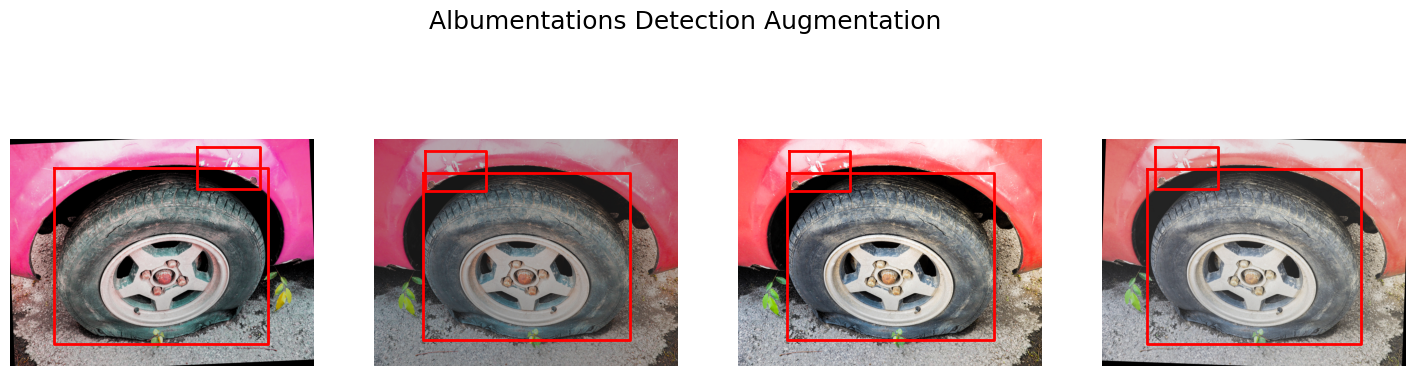

In [10]:
def visualize_augmented_detection(index, num_samples=4):
    img_info = train_data["images"][index]
    img_id = img_info["id"]
    fname = img_info["file_name"]

    path = os.path.join(train_img_dir, fname)
    img = Image.open(path).convert("RGB")

    # collect annotation bboxes in xyxy format
    boxes = []
    labels = []
    for ann in train_data["annotations"]:
        if ann["image_id"] == img_id:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x+w, y+h])
            labels.append(ann["category_id"])

    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    wrapper = AlbumentationsDetectionWrapper(train_transform)

    fig, axs = plt.subplots(1, num_samples, figsize=(18, 5))
    fig.suptitle("Albumentations Detection Augmentation", fontsize=18)

    for i in range(num_samples):
        target = {"boxes": boxes.clone(), "labels": labels.clone()}
        aug_img, aug_target = wrapper(img, target)

        axs[i].imshow(aug_img)

        # draw boxes
        for (x1, y1, x2, y2) in aug_target["boxes"]:
            axs[i].plot(
                [x1, x2, x2, x1, x1],
                [y1, y1, y2, y2, y1],
                linewidth=2,
                color="red",
            )
        axs[i].axis("off")

    plt.show()


# Test it
visualize_augmented_detection(0, num_samples=4)


In [11]:
from collections import defaultdict

class_counts = defaultdict(int)

for ann in train_data["annotations"]:
    class_counts[ann["category_id"]] += 1

print("Class Distribution:")
for cid in sorted(class_counts):
    print(f"  Class {cid}: {class_counts[cid]}")


Class Distribution:
  Class 1: 1806
  Class 2: 2560
  Class 3: 651
  Class 4: 475
  Class 5: 494
  Class 6: 225
